100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.51MB/s]
Epoch 10/10: 100%|██████████| 469/469 [00:10<00:00, 44.37it/s, loss=11.1]


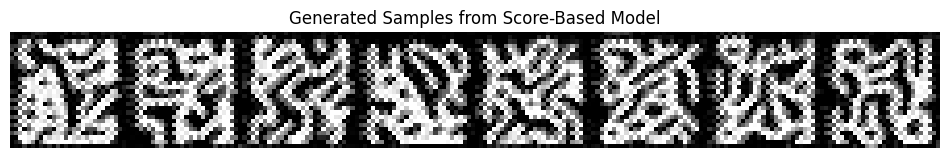

In [1]:
# Score-Based Generative Model with Score Matching and Langevin Dynamics (MNIST)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # scale to [-1, 1]
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Score network: predicts the gradient of log-density
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Score matching loss (denoising score matching)
def score_matching_loss(model, x, sigma):
    noise = torch.randn_like(x) * sigma
    x_noisy = x + noise
    score = model(x_noisy)
    target = -noise / sigma**2
    loss = F.mse_loss(score, target)
    return loss

# Langevin dynamics for sampling
def langevin_sampling(model, shape, n_steps=60, step_size=0.1, noise_scale=0.01):
    x = torch.randn(shape).to(device)
    x.requires_grad = True
    for _ in range(n_steps):
        score = model(x)
        noise = torch.randn_like(x) * noise_scale
        x.data += step_size * score + noise
        x.data = x.data.clamp(-1, 1)
    return x.detach()

# Model and optimizer
model = ScoreNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/10")
    for x, _ in pbar:
        x = x.to(device)
        loss = score_matching_loss(model, x, sigma=0.1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

# Sampling
samples = langevin_sampling(model, (8, 1, 28, 28), n_steps=100)

# Visualization
def show_images(images, title=""):
    images = (images + 1) / 2  # Rescale to [0, 1]
    grid = torch.cat([img.squeeze(0) for img in images], dim=1).cpu().numpy()
    plt.figure(figsize=(12, 2))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

show_images(samples, title="Generated Samples from Score-Based Model")
